In [1]:
using FEM, Potential, Diffusity, PyPlot, Printf, JLD, Dierckx, AlphaBeta, LinearAlgebra

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$

In [3]:
sigma_kref = 10.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq
F_xref = force_harmonic_well_k_mean.(xref, kref, xavg);

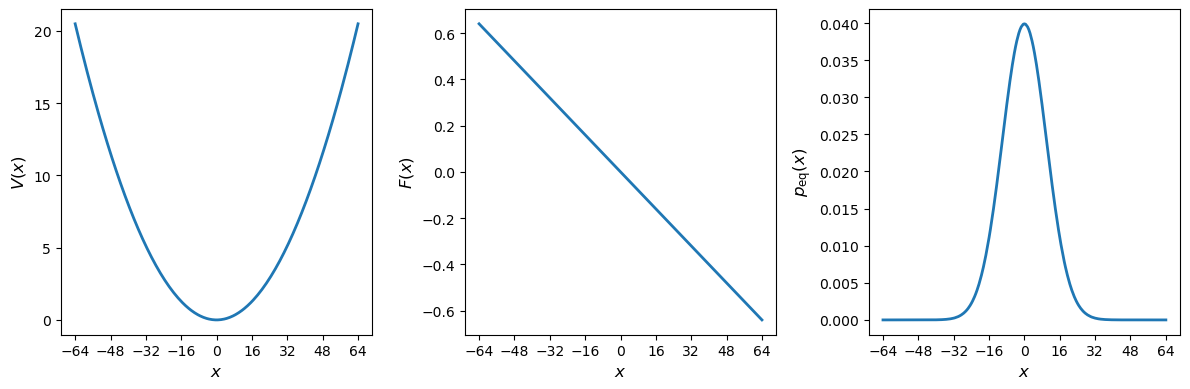

In [37]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, F_xref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$F(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[3]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/harmonic_potential_force.svg")
plt.show()

### Part 3: Distance-dependent diffusion coefficient $D(x)$

In [4]:
xleft = -64
xright = 64
yleft = 250
yright = 750
c = 500
D_constant = c
D_array = Diffusity.linear.(xleft, xright, yleft, yright, xref, c)
D_spl = Spline1D(xref[:,1], D_array[:,1])
eta_array = D_array .- D_constant

dDdx_xref = zeros(N)
for idx = 1:N
    dDdx_xref[idx] = derivative(D_spl, xref[idx])
end

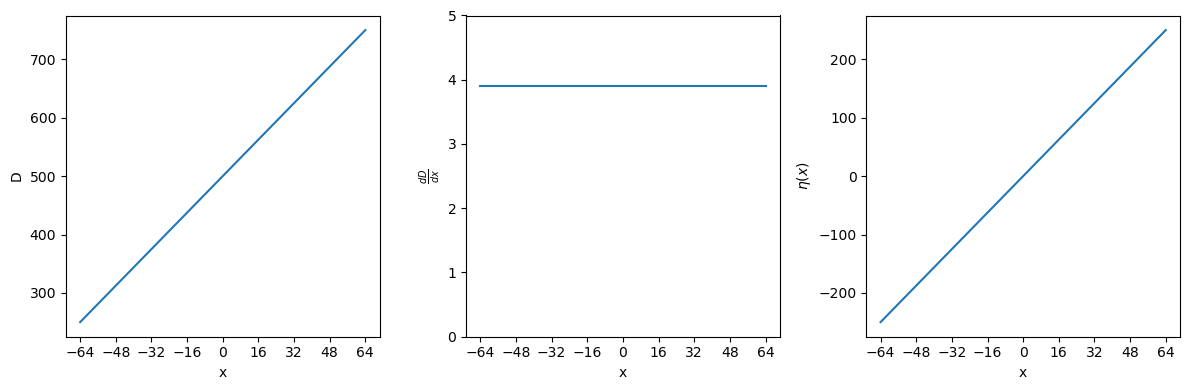

In [38]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, D_array)
ax.set_xlabel("x")
ax.set_ylabel("D")
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, dDdx_xref)
ax.set_xlabel("x")
ax.set_ylabel("\$\\frac{dD}{dx}\$")
ax.set_xticks(-64:16:64)
ax.set_ylim(0,5)

ax = axes[3]
ax.plot(xref, eta_array)
ax.set_xlabel("x")
ax.set_ylabel("\$\\eta(x)\$")
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.svg")
plt.show()

### Part 4: Eigenbasis of $\textbf{H}^0$

In [6]:
eigenvalues_H0, eigenvec_mat_H0, rho_eq = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_constant, Nv);

### Part 5: Eigenbasis of $\textbf{H}$

In [7]:
eigenvalues_H, eigenvec_mat_H = Diffusity.solven_eigen_H(Nv, xref, eigenvec_mat_H0, eigenvalues_H0, N, F_xref, eta_array);

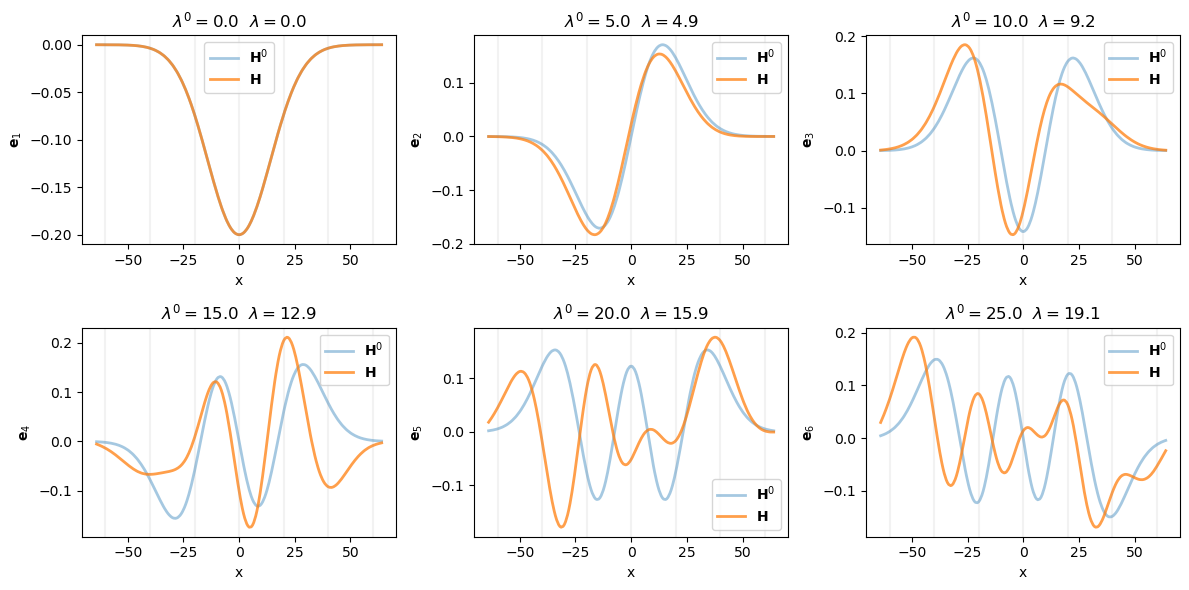

In [39]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        ax = axes[row_id, col_id]
        title = @sprintf "\$\\lambda^0=%.1f\$  \$\\lambda=%.1f\$" eigenvalues_H0[idx_eigvector] eigenvalues_H[idx_eigvector]
        if transpose(eigenvec_mat_H[:, idx_eigvector]) * eigenvec_mat_H0[:, idx_eigvector] < 0.
            ax.plot(xref, -eigenvec_mat_H0[:, idx_eigvector], label="\$\\mathbf{H}^0\$", alpha=0.4, linewidth=2)
        else
            ax.plot(xref, eigenvec_mat_H0[:, idx_eigvector], label="\$\\mathbf{H}^0\$", alpha=0.4, linewidth=2)
        end
        ax.plot(xref, eigenvec_mat_H[:, idx_eigvector], label="\$\\mathbf{H}\$", alpha=0.75, linewidth=2)
        ax.set_title(title)
        ax.legend()
        ax.set_ylabel(@sprintf "\$\\mathbf{e}_%d\$" idx_eigvector)
        ax.set_xlabel("x")
        for xvalue=-60:20:60
            ax.axvline(xvalue, color="grey", alpha=0.1)
        end
        
        idx_eigvector += 1    
    end
end
plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/H0_H_eigenbasis.svg")
plt.show()

### Part 6: Check Orthonormal

In [31]:
idx_i = 5
idx_j = 5
sum(w0 .* eigenvec_mat_H[:, idx_i] .* eigenvec_mat_H[:, idx_j])

0.9999999992573405